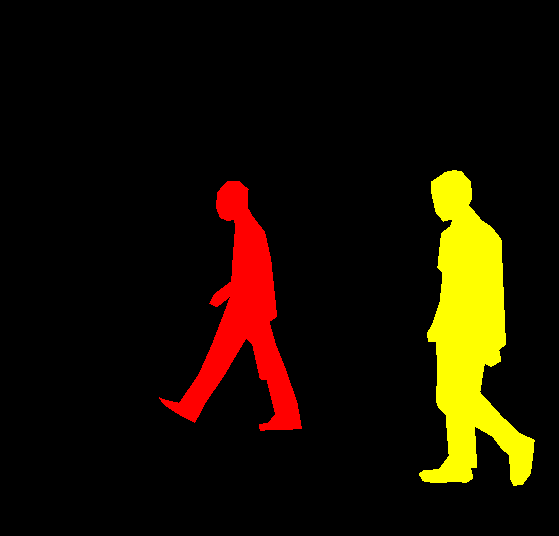

In [9]:
from PIL import Image

Image.open('./dataset/PennFudanPed/PNGImages/FudanPed00001.png')

mask = Image.open('./dataset/PennFudanPed/PedMasks/FudanPed00001_mask.png')

mask = mask.convert("P")

mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])

mask

In [10]:
import os
import torch
import numpy as np
import torch.utils.data
from PIL import Image

In [48]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance with 0 being background
        mask = Image.open(mask_path)
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set of binary masks
        masks = mask == obj_ids[:, None, None]
        

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [47]:
dataset = PennFudanDataset('./dataset/PennFudanPed/')

dataset[0]

tensor([419., 170., 534., 485.])


(<PIL.Image.Image image mode=RGB size=559x536>,
 {'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([35358., 36225.]),
  'iscrowd': tensor([0, 0])})

In [51]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has num_classes which is user-defined
num_classes = 2  # 1 class (person) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

1024


In [52]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features

# FasterRCNN needs to know the number of output channels in a backbone. 
# For mobilenet_v2, it's 1280. So we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and aspect ratios 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will use to perform the region of 
# interest cropping, as well as the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an OrderedDict[Tensor], 
# and in featmap_names you can choose which feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

C:\Users\x9172\anaconda3\envs\PT\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\x9172/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [53]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [56]:
import utils
import transforms as T
from engine import train_one_epoch, evaluate


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))

    return T.Compose(transforms)

In [59]:
# use the PennFudan dataset and defined transformations
dataset = PennFudanDataset('./dataset/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('./dataset/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# the dataset has two classes only - background and person
num_classes = 2

# get the model using the helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# the learning rate scheduler decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# training
num_epochs = 10
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

    # update the learning rate
    lr_scheduler.step()

    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:05:43  lr: 0.000090  loss: 2.7486 (2.7486)  loss_classifier: 0.7413 (0.7413)  loss_box_reg: 0.3342 (0.3342)  loss_mask: 1.6469 (1.6469)  loss_objectness: 0.0242 (0.0242)  loss_rpn_box_reg: 0.0021 (0.0021)  time: 5.7283  data: 0.0570  max mem: 2335
Epoch: [0]  [10/60]  eta: 0:00:45  lr: 0.000936  loss: 1.3595 (1.7135)  loss_classifier: 0.5226 (0.4833)  loss_box_reg: 0.2927 (0.3032)  loss_mask: 0.6779 (0.9073)  loss_objectness: 0.0128 (0.0148)  loss_rpn_box_reg: 0.0045 (0.0049)  time: 0.9138  data: 0.0415  max mem: 3490
Epoch: [0]  [20/60]  eta: 0:00:27  lr: 0.001783  loss: 0.9975 (1.2278)  loss_classifier: 0.2269 (0.3338)  loss_box_reg: 0.2927 (0.2857)  loss_mask: 0.3504 (0.5869)  loss_objectness: 0.0114 (0.0169)  loss_rpn_box_reg: 0.0035 (0.0045)  time: 0.4287  data: 0.0391  max mem: 3490
Epoch: [0]  [30/60]  eta: 0:00:19  lr: 0.002629  loss: 0.6034 (1.0146)  loss_classifier: 0.0958 (0.2546)  loss_box_reg: 0.2714 (0.2864)  loss_mask: 0.1799 (0.4544)  loss_ob

Epoch: [2]  [ 0/60]  eta: 0:00:21  lr: 0.005000  loss: 0.1993 (0.1993)  loss_classifier: 0.0152 (0.0152)  loss_box_reg: 0.0373 (0.0373)  loss_mask: 0.1398 (0.1398)  loss_objectness: 0.0006 (0.0006)  loss_rpn_box_reg: 0.0064 (0.0064)  time: 0.3651  data: 0.0240  max mem: 3532
Epoch: [2]  [10/60]  eta: 0:00:19  lr: 0.005000  loss: 0.2441 (0.2379)  loss_classifier: 0.0272 (0.0301)  loss_box_reg: 0.0520 (0.0678)  loss_mask: 0.1247 (0.1332)  loss_objectness: 0.0006 (0.0016)  loss_rpn_box_reg: 0.0032 (0.0051)  time: 0.3961  data: 0.0255  max mem: 3532
Epoch: [2]  [20/60]  eta: 0:00:15  lr: 0.005000  loss: 0.2441 (0.2482)  loss_classifier: 0.0309 (0.0331)  loss_box_reg: 0.0683 (0.0767)  loss_mask: 0.1241 (0.1326)  loss_objectness: 0.0006 (0.0012)  loss_rpn_box_reg: 0.0032 (0.0046)  time: 0.3974  data: 0.0254  max mem: 3532
Epoch: [2]  [30/60]  eta: 0:00:11  lr: 0.005000  loss: 0.2181 (0.2398)  loss_classifier: 0.0310 (0.0344)  loss_box_reg: 0.0565 (0.0720)  loss_mask: 0.1134 (0.1276)  loss_ob

Epoch: [4]  [ 0/60]  eta: 0:00:22  lr: 0.000500  loss: 0.1387 (0.1387)  loss_classifier: 0.0208 (0.0208)  loss_box_reg: 0.0230 (0.0230)  loss_mask: 0.0938 (0.0938)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 0.3791  data: 0.0320  max mem: 3532
Epoch: [4]  [10/60]  eta: 0:00:22  lr: 0.000500  loss: 0.2196 (0.2151)  loss_classifier: 0.0273 (0.0315)  loss_box_reg: 0.0477 (0.0556)  loss_mask: 0.1223 (0.1232)  loss_objectness: 0.0003 (0.0012)  loss_rpn_box_reg: 0.0033 (0.0036)  time: 0.4516  data: 0.0322  max mem: 3532
Epoch: [4]  [20/60]  eta: 0:00:18  lr: 0.000500  loss: 0.1712 (0.2019)  loss_classifier: 0.0306 (0.0300)  loss_box_reg: 0.0416 (0.0492)  loss_mask: 0.1069 (0.1185)  loss_objectness: 0.0004 (0.0010)  loss_rpn_box_reg: 0.0032 (0.0033)  time: 0.4542  data: 0.0292  max mem: 3532
Epoch: [4]  [30/60]  eta: 0:00:13  lr: 0.000500  loss: 0.1642 (0.1959)  loss_classifier: 0.0224 (0.0287)  loss_box_reg: 0.0327 (0.0461)  loss_mask: 0.1037 (0.1173)  loss_ob

Epoch: [6]  [ 0/60]  eta: 0:00:23  lr: 0.000050  loss: 0.2256 (0.2256)  loss_classifier: 0.0477 (0.0477)  loss_box_reg: 0.0535 (0.0535)  loss_mask: 0.1223 (0.1223)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0017 (0.0017)  time: 0.3941  data: 0.0380  max mem: 3532
Epoch: [6]  [10/60]  eta: 0:00:21  lr: 0.000050  loss: 0.1856 (0.1821)  loss_classifier: 0.0267 (0.0277)  loss_box_reg: 0.0448 (0.0404)  loss_mask: 0.1097 (0.1114)  loss_objectness: 0.0003 (0.0006)  loss_rpn_box_reg: 0.0020 (0.0021)  time: 0.4250  data: 0.0284  max mem: 3532
Epoch: [6]  [20/60]  eta: 0:00:16  lr: 0.000050  loss: 0.1764 (0.1731)  loss_classifier: 0.0239 (0.0259)  loss_box_reg: 0.0358 (0.0362)  loss_mask: 0.1083 (0.1084)  loss_objectness: 0.0002 (0.0006)  loss_rpn_box_reg: 0.0020 (0.0020)  time: 0.4144  data: 0.0254  max mem: 3532
Epoch: [6]  [30/60]  eta: 0:00:12  lr: 0.000050  loss: 0.1762 (0.1771)  loss_classifier: 0.0230 (0.0257)  loss_box_reg: 0.0363 (0.0378)  loss_mask: 0.1095 (0.1107)  loss_ob

Epoch: [8]  [ 0/60]  eta: 0:00:22  lr: 0.000050  loss: 0.1955 (0.1955)  loss_classifier: 0.0355 (0.0355)  loss_box_reg: 0.0393 (0.0393)  loss_mask: 0.1191 (0.1191)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0016 (0.0016)  time: 0.3771  data: 0.0290  max mem: 3532
Epoch: [8]  [10/60]  eta: 0:00:24  lr: 0.000050  loss: 0.1896 (0.1988)  loss_classifier: 0.0264 (0.0285)  loss_box_reg: 0.0405 (0.0448)  loss_mask: 0.1189 (0.1216)  loss_objectness: 0.0005 (0.0011)  loss_rpn_box_reg: 0.0023 (0.0028)  time: 0.4887  data: 0.0302  max mem: 3532
Epoch: [8]  [20/60]  eta: 0:00:19  lr: 0.000050  loss: 0.1748 (0.1956)  loss_classifier: 0.0232 (0.0284)  loss_box_reg: 0.0304 (0.0443)  loss_mask: 0.1167 (0.1179)  loss_objectness: 0.0004 (0.0020)  loss_rpn_box_reg: 0.0025 (0.0029)  time: 0.5016  data: 0.0300  max mem: 3532
Epoch: [8]  [30/60]  eta: 0:00:14  lr: 0.000050  loss: 0.1685 (0.1925)  loss_classifier: 0.0218 (0.0277)  loss_box_reg: 0.0282 (0.0436)  loss_mask: 0.1122 (0.1168)  loss_ob

In [60]:
# pick one image from the test set
img, _ = dataset_test[0]

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

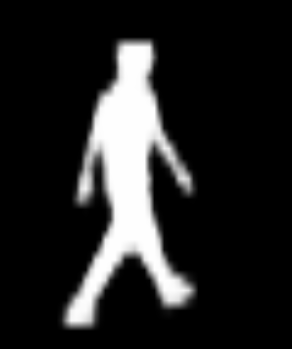

In [61]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())